# ***Custom MLP using mini-batch GD, in Numpy***

## Importing libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os

## *Importing Fashion MNIST dataset* from `torchvision.datasets`

In [2]:
'''Importing Fashion MNIST dataset'''
data_path1='E:/Code/my_code'
if not os.path.isdir(data_path1+"/data_temp/"):
    os.mkdir(data_path1+"/data_temp/")
fashion_data_train = datasets.FashionMNIST(root = data_path1 + '/data_temp/fashion_mnist_data1', 
                            train = True, 
                            download = True, 
                            transform=transforms.ToTensor())

sample_size = len(fashion_data_train)

fashion_labels = {
    0: "Tee",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

### *Visualization of the Fashion MNIST dataset*

784


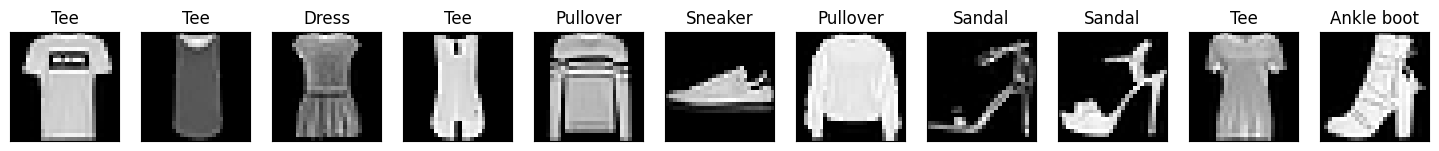

In [3]:
'''Displaying images and labels from 1 to 11'''
plt.figure(figsize=(20,40))
for idx in range(1,12):
  plt.subplot(1,12,idx).imshow(fashion_data_train[idx][0].squeeze().numpy(),
                               cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(fashion_labels[fashion_data_train[idx][1]])

#Each element of the data_train, from MNIST of torch is a (label, image) pair, each image is 28x28
fashion_data = np.zeros((sample_size,28*28), dtype = np.float32)
fashion_label = np.zeros((sample_size,), dtype = np.int64)
for idx, (img_data, img_label) in enumerate(fashion_data_train):
   fashion_data[idx]= img_data.squeeze().numpy().flatten() #[1,28,28] to [28,28] to [784]
   fashion_label[idx] = img_label
   
print(len(fashion_data[10]))

## Custom *softmax function* for classification

The softmax function is defined as:

$$
\text{softmax}(z_i) \;=\; \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

where:
- $(z_i)$ is the \(i\)-th input,
- $(K)$ is the total number of classes,
- The denominator normalizes the values so they sum to 1.

In [4]:
def softmax_stable(Z):
    max_Z = np.max(Z,axis = 0, keepdims= True) #Z = (d,N) => Each of the datapoint is a column vector so axis =0
    Z= Z- max_Z
    Z = np.clip(Z,-100,100)
    exp_Z = np.exp(Z)
    softmax_Z = exp_Z/ exp_Z.sum(axis=0, keepdims = True)
    return softmax_Z

## *Rectified Linear Unit* (ReLU)

<p align="center">
  <img src="Images/Relu.png" alt="ReLU" title = "ReLU" width="400"/> <br>
  <em> ReLU activation </em>
</p>

In [5]:
def relu(Z):
    A = np.maximum(Z,0) #(d,N)
    return A

## *Cross entropy loss*

In [6]:
def cross_entropy_MB (y_hat, y): #For a mini batch, return mean loss of the whole batch
    idx = range(y_hat.shape[1])
    J = -np.mean(np.log (y_hat[y,idx]+1e-9))
    return J

## *Initilize weights and biases*

In [7]:
def mlp_initialize_MB (d0,d1,d2,d3, d4):
    w1 = np.random.randn(d0,d1)*np.sqrt(2/d0)
    b1 = np.zeros((d1,1))
    w2 = np.random.randn(d1,d2)*np.sqrt(2/d1)
    b2 = np.zeros((d2,1))
    w3 = np.random.randn (d2,d3)*np.sqrt(2/d2)
    b3 = np.zeros((d3,1))
    w4 = np.random.randn (d3,d4)*np.sqrt(2/d3)
    b4 = np.zeros((d4,1))
    return w1,b1,w2,b2,w3,b3,w4,b4

## *Feedforward but for evaluation*

In [8]:
def mlp_predict_MB(X, w1,b1,w2,b2,w3,b3,w4,b4): #X(d0,N)
   Z1 = w1.T@X + b1 #(d1,N)
   A1 = relu(Z1)
   Z2 = w2.T@A1 + b2 #(d2,N)
   A2 = relu(Z2)
   Z3 = w3.T@A2 + b3 #(d3,N)
   A3 = relu(Z3)
   Z4 = w4.T@A3 + b4 #(d4,N)
   pred_label = np.argmax(Z4, axis = 0)
   return pred_label

## *Feedforward for training*

In [9]:
def feedforward_MB(w1,b1,w2,b2,w3,b3,w4,b4,X):
    Z1 = w1.T@X + b1 #(d1,N)
    A1 = relu(Z1)
    Z2 = w2.T@A1 + b2 #(d2,N)
    A2 = relu(Z2)
    Z3 = w3.T@A2 + b3 #(d3,N)
    A3 = relu(Z3)
    Z4 = w4.T@A3 + b4 #(d4,N)
    y_hat = softmax_stable(Z4) #(d4,N)
    return(Z1,A1,Z2,A2,Z3,A3,Z4,y_hat)

## *Backpropagation and Gradient computation*

In [10]:
def backpropagation_MB(w1,w2,w3,w4,Z1,A1,Z2,A2,Z3,A3, Z4,
                    x,y,y_hat, batch_size):
    y_hat_copy = y_hat.copy()
    idx = range(y_hat_copy.shape[1])
    y_hat_copy[y,idx] -=1

    e4 = y_hat_copy/batch_size #(d4,N)
    dw4 = A3@e4.T #(d3,d4)
    db4 = np.sum(e4,axis=1).reshape(-1,1) #(d4,) 

    e3 = w4@e4 #(d3,N)
    e3[Z3<=0]=0 #Manual ReLU
    dw3 = A2@e3.T #(d2,d3)
    db3 = np.sum(e3,axis=1).reshape(-1,1) #(d3,) 

    e2 = w3@e3 #(d2,N)
    e2[Z2<=0]=0 #Equivalent to multiply with the gradient of Relu (f' = 0 if z<=0 or 1 if z>0)
    dw2 = A1@e2.T #(d1,d2)
    db2 = np.sum(e2,axis=1).reshape(-1,1) #(d2,) 

    e1 = w2@e2 #(d1,N)
    e1[Z1<=0]=0
    dw1 = x@e1.T #(d0,d1)
    db1 = np.sum(e1,axis=1).reshape(-1,1) #(d1,) 
    return (dw1,db1,dw2,db2,dw3,db3,dw4,db4)

## *Training function*

In [11]:
'''Mini batch GD'''

def mlp_fit_MB (w1,b1,w2,b2,w3,b3,w4,b4, train_data, train_label, eta, epoch, num_samples, batch_size):
    L_iters = np.zeros(epoch)
    for iter in range (epoch):
        total_loss = 0
        '''Shuffle dataset'''
        shuffle = np.random.permutation(num_samples) #Randomly return a pertumed range
        data_shuffle = train_data[shuffle,:]
        label_shuffle = train_label[shuffle]

        '''Arrange into MINI BATCHES'''
        for i in range (0,num_samples,batch_size): 
            x = data_shuffle[i:i+batch_size,:].T #(d0,N)
            y = label_shuffle[i:i+batch_size] #(d4,)

            '''FEED FORWARD PROCESS'''
            Z1,A1,Z2,A2,Z3,A3,Z4,y_hat = feedforward_MB(w1,b1,w2,b2,w3,b3,w4,b4,x)

            '''Check if values blows up to inifnity or NaN'''
            if np.any(np.isnan(Z4)) or np.any(np.isinf(Z4)):
               print(f"❌ NaN/Inf detected in Z4 at epoch {iter}, batch {i}")
               print(f"Max Z4: {np.max(Z4)}, Min Z4: {np.min(Z4)}")
               return w1, b1, w2, b2, w3, b3, w4, b4, L_iters

            '''Record loss'''
            loss = cross_entropy_MB(y_hat, y)
            total_loss += loss

            '''Backpropagation'''
            dw1,db1,dw2,db2,dw3,db3,dw4,db4 = backpropagation_MB(w1,w2,w3,w4, 
                                                      Z1,A1,Z2,A2,Z3,A3,Z4,
                                                      x,y,y_hat, batch_size)
            
            '''Alternating weights and biases'''
            lambda_reg = 1e-5
            w4 -= eta*(dw4 + lambda_reg*w4)
            b4 -= eta*db4
            # print("Max dw4:", np.max(np.abs(dw4)))
            # print("Max lambda_reg*w4:", np.max(np.abs(lambda_reg * w4)))

            w3 -= eta*(dw3+ lambda_reg*w3)
            b3 -= eta*db3
            w2 -= eta*(dw2+ lambda_reg*w2)
            b2 -= eta*db2
            w1 -= eta*(dw1+ lambda_reg*w1)
            b1 -= eta*db1

        '''Loss calculation'''
        avg_loss = total_loss*batch_size / num_samples
        L_iters[iter] = avg_loss

        '''Print loss'''
        if(iter%4==0): 
            print('Epoch\'s iter: %d, average loss: %f' %(iter, avg_loss))
            
    return (w1,b1,w2,b2,w3,b3,w4,b4,L_iters)


## ***Training***

In [16]:
'''Initialization of Network depth'''
d0 = fashion_data.shape[1]
d1 = 30
d2 = 15
d3 = 10
d4 = 10
eta = 0.01
epoch = 1000
sample_size = len(fashion_data_train)

'''Run and optimize model'''
w1,b1,w2,b2,w3,b3,w4,b4 = mlp_initialize_MB(d0,d1,d2,d3,d4)
w1,b1,w2,b2,w3,b3,w4,b4,L_iters = mlp_fit_MB(w1,b1,w2,b2,w3,b3,w4,b4, fashion_data, 
                                            fashion_label, eta, epoch, sample_size, 100)

Epoch's iter: 0, average loss: 1.557157
Epoch's iter: 4, average loss: 0.490591
Epoch's iter: 8, average loss: 0.431028
Epoch's iter: 12, average loss: 0.400205
Epoch's iter: 16, average loss: 0.378848
Epoch's iter: 20, average loss: 0.360391
Epoch's iter: 24, average loss: 0.346708
Epoch's iter: 28, average loss: 0.335434
Epoch's iter: 32, average loss: 0.325431
Epoch's iter: 36, average loss: 0.316965
Epoch's iter: 40, average loss: 0.310074
Epoch's iter: 44, average loss: 0.302038
Epoch's iter: 48, average loss: 0.296976
Epoch's iter: 52, average loss: 0.291547
Epoch's iter: 56, average loss: 0.285949
Epoch's iter: 60, average loss: 0.282446
Epoch's iter: 64, average loss: 0.278161
Epoch's iter: 68, average loss: 0.273405
Epoch's iter: 72, average loss: 0.270047
Epoch's iter: 76, average loss: 0.265048
Epoch's iter: 80, average loss: 0.263051
Epoch's iter: 84, average loss: 0.259327
Epoch's iter: 88, average loss: 0.254868
Epoch's iter: 92, average loss: 0.252885
Epoch's iter: 96, a

## *Plotting*

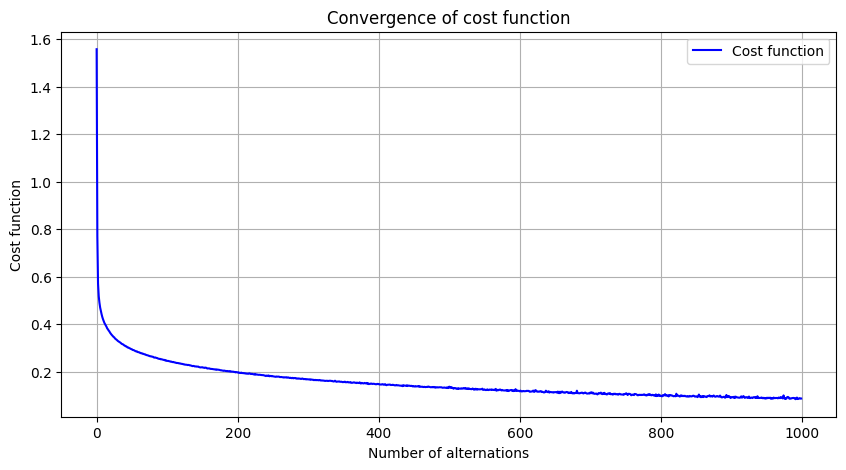

In [17]:
'''Plotting of cost function'''
plt.figure(figsize = (10,5))
plt.title('Convergence of cost function')
idx = np.array(range(epoch))
loss_graph = plt.plot(idx, L_iters, c = 'b')
plt.xlabel('Number of alternations')
plt.ylabel('Cost function')
plt.grid('True')
plt.legend(loss_graph, ['Cost function'])

## Evaluating model accuracy

In [18]:
'''Model accuracy'''
total_acc = 0
for i in range(sample_size):
    x = fashion_data[i,:].reshape(-1,1)
    y_pred = mlp_predict_MB(x,w1,b1,w2,b2,w3,b3,w4,b4).item()
    total_acc += (y_pred==fashion_label[i])
accuracy = 100*total_acc.item()/sample_size
print('The accuracy of the MLP: %f%%' %(accuracy))

The accuracy of the MLP: 97.526667%


tensor(0.) tensor(1.)
Image 59543 is wrong, true label: Coat and predicted label: Shirt
Image 46050 is wrong, true label: Shirt and predicted label: Dress
Correct predictions: 198 / 200

The accuracy of the randomly selected 100 samples from the training set is 99.0000 %


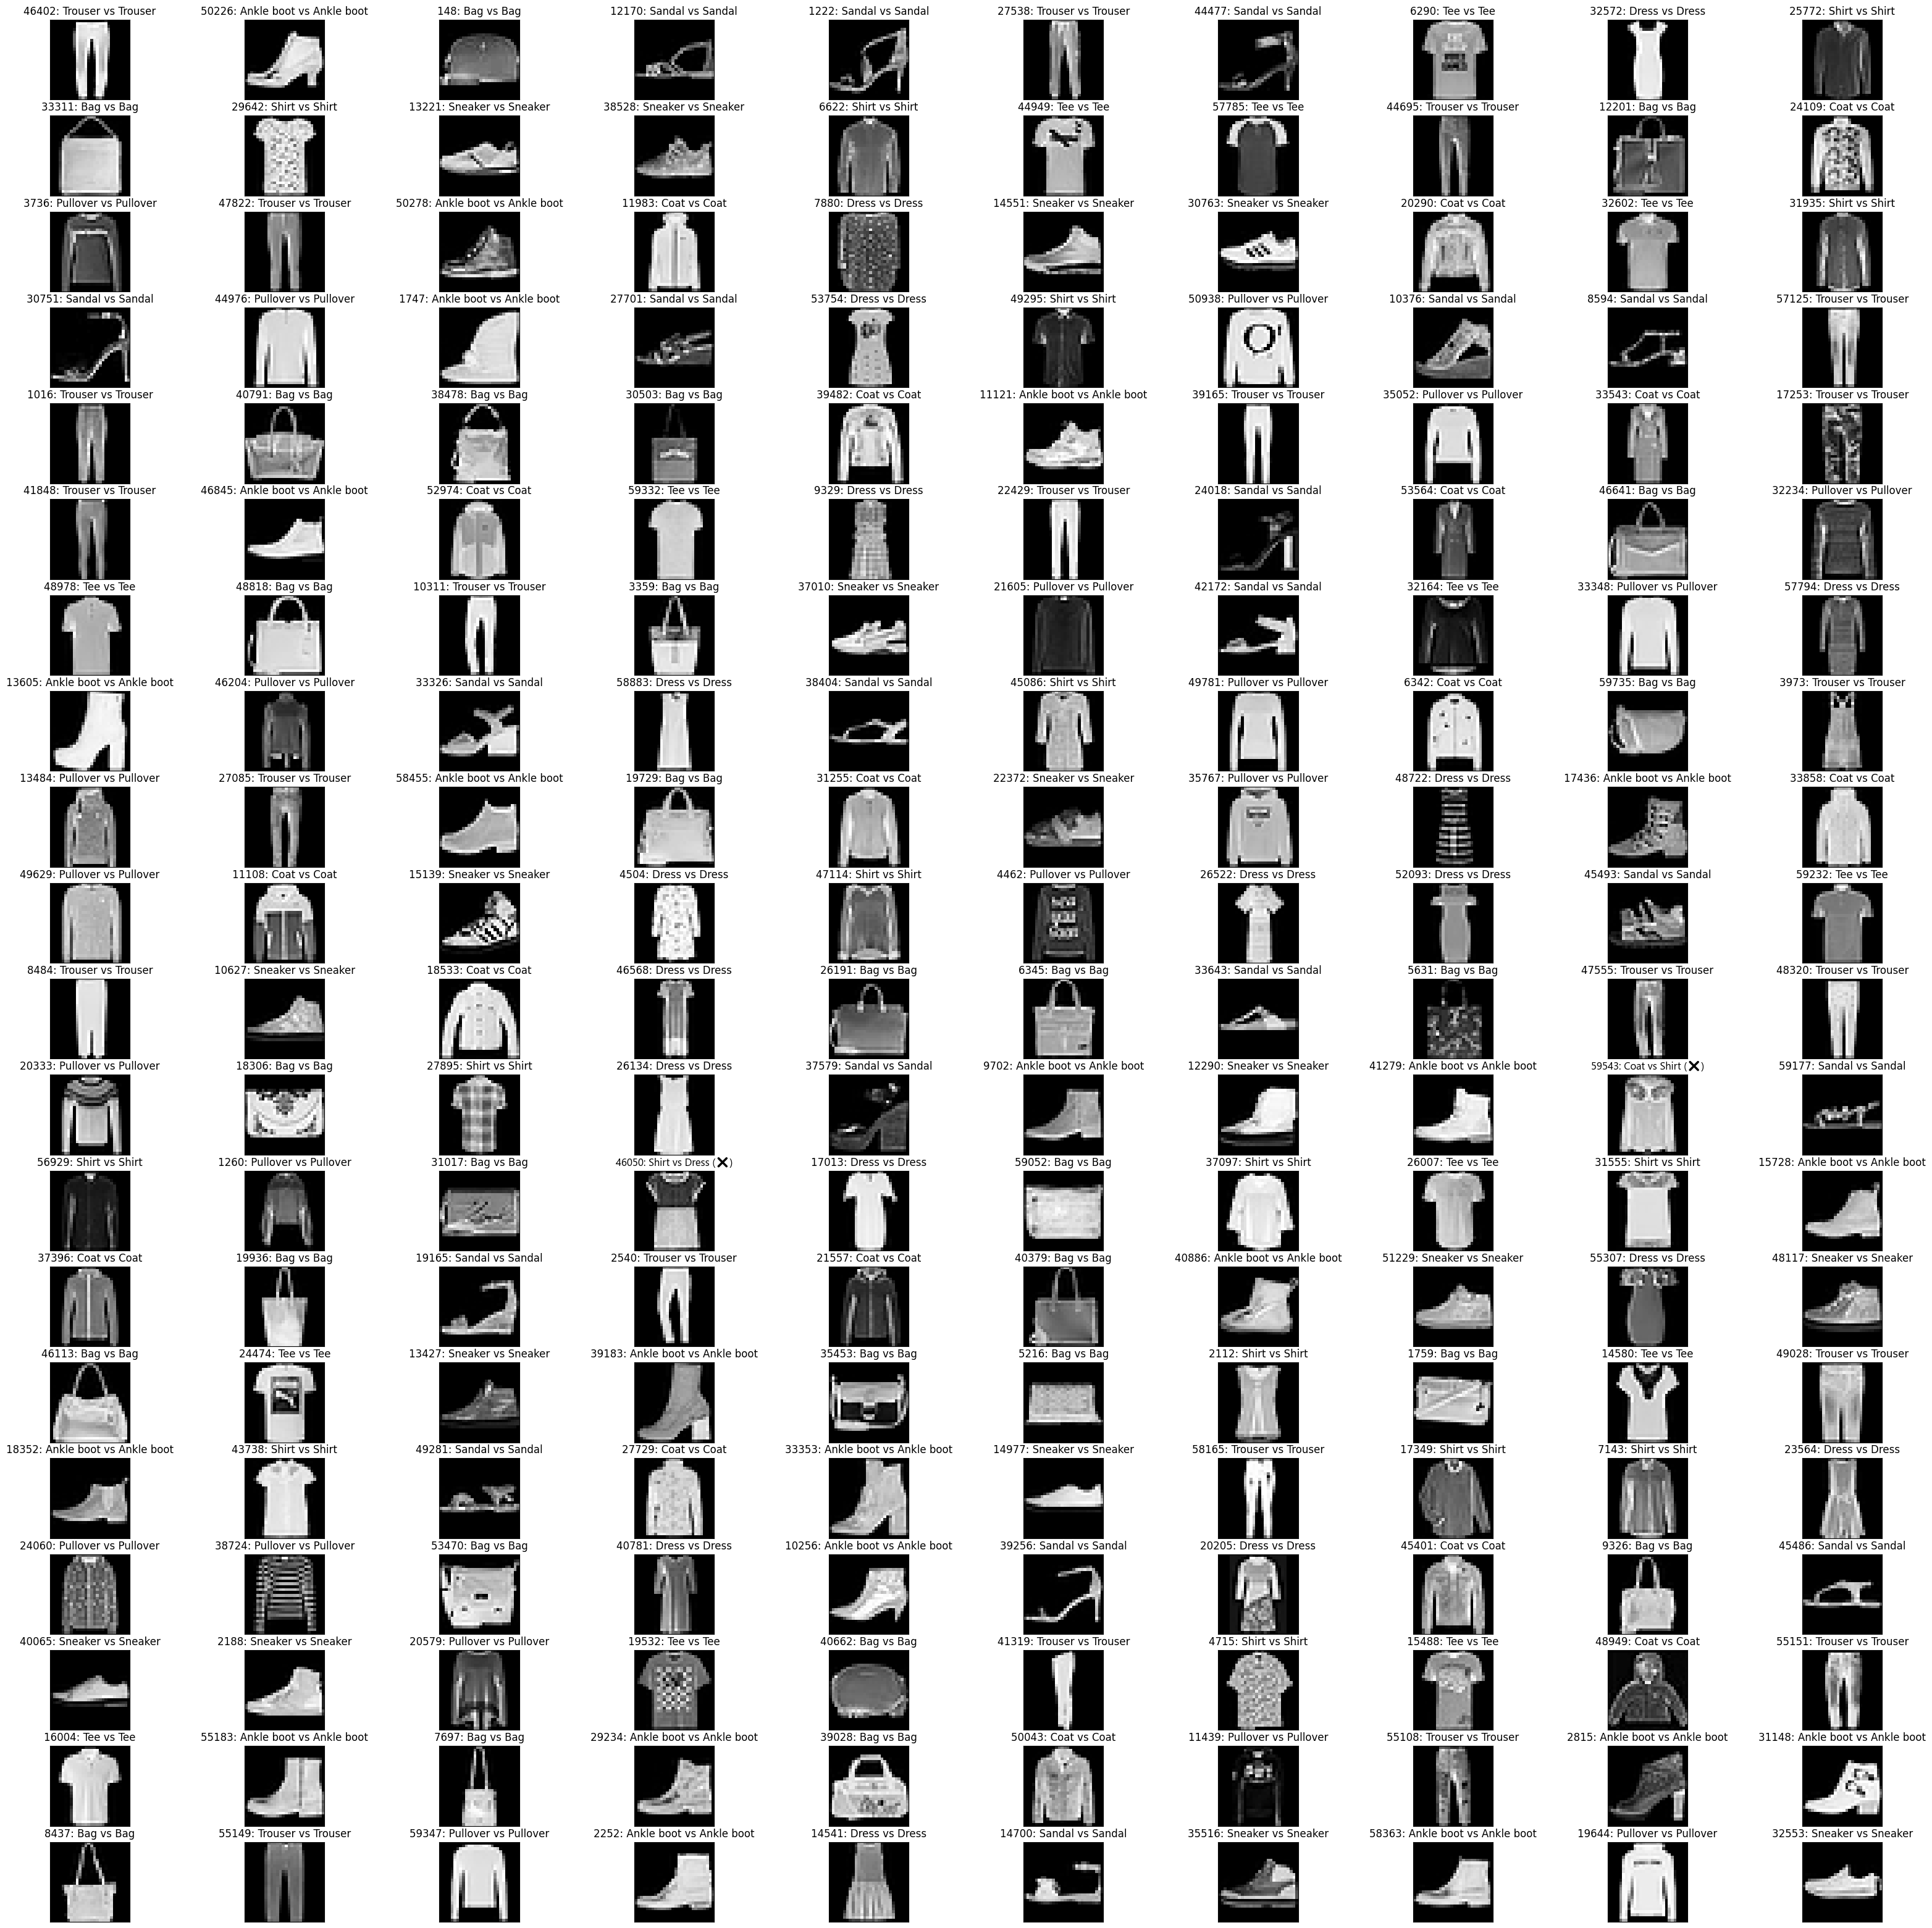

In [19]:

def illustration_test_fashion (test_size, dataset, w1, b1, w2, b2,w3,b3,w4,b4):
    X = np.zeros((784,test_size))
    true_labels = np.zeros(test_size, dtype=int)
    images= []

    for idx in range (test_size):
        i = np.random.randint(low=1, high= len(dataset))
        img_tensor, img_label = dataset[i]
        X[:,idx] = img_tensor.squeeze().numpy().flatten()
        true_labels[idx] = img_label
        images.append((i, img_tensor))
    
    pred_labels = mlp_predict_MB(X,w1,b1,w2,b2,w3,b3,w4,b4)

    count = 0
    plt.figure(figsize = (40,40))
    for idx in range (test_size):
        i, img_tensor = images[idx]
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]
        plt.subplot(test_size//10,10,idx+1).imshow(img_tensor.squeeze().numpy(),cmap='gray')
        plt.xticks([])
        plt.yticks([])

        if pred_label != true_label:
            plt.title(f'{i}: {fashion_labels[true_label]} vs {fashion_labels[pred_label]} (❌)',fontname='Segoe UI Emoji')
            print(f'Image {i} is wrong, true label: {fashion_labels[true_label]} and predicted label: {fashion_labels[pred_label]}')
        else: 
            plt.title(f'{i}: {fashion_labels[true_label]} vs {fashion_labels[pred_label]}')
            count+=1
    print(f'Correct predictions: {count} / {test_size}')
    acc = 100*count/test_size
    return acc

print(fashion_data_train[0][0].min(), fashion_data_train[0][0].max())  # Should be in [0, 1] for ToTensor()


acc_train = illustration_test_fashion(200, fashion_data_train,w1,b1,w2,b2,w3,b3,w4,b4)
print('\nThe accuracy of the randomly selected 100 samples from the training set is %.4f %%' %(acc_train))

## ***Evaluation***

In [20]:
fashion_data_test = datasets.FashionMNIST(root = data_path1 + '/data_temp/fashion_mnist_data1',
                           train = False,
                           download = True,
                           transform=transforms.ToTensor())

test_num = len(fashion_data_test)

### *Evaluate the model on the evaluation dataset*

The accuracy of the MLP: 85.0900% 

Image 8298 is wrong, true label: Pullover and predicted label: Shirt
Image 2894 is wrong, true label: Pullover and predicted label: Coat
Image 4615 is wrong, true label: Ankle boot and predicted label: Tee
Image 9835 is wrong, true label: Ankle boot and predicted label: Sneaker
Image 6240 is wrong, true label: Tee and predicted label: Shirt
Image 8140 is wrong, true label: Coat and predicted label: Pullover
Image 1116 is wrong, true label: Pullover and predicted label: Shirt
Image 8300 is wrong, true label: Coat and predicted label: Shirt
Image 2919 is wrong, true label: Coat and predicted label: Shirt
Image 4093 is wrong, true label: Tee and predicted label: Shirt
Image 5338 is wrong, true label: Tee and predicted label: Bag
Image 6844 is wrong, true label: Shirt and predicted label: Coat
Image 3338 is wrong, true label: Shirt and predicted label: Coat
Image 6952 is wrong, true label: Sneaker and predicted label: Sandal
Image 4336 is wrong, true lab

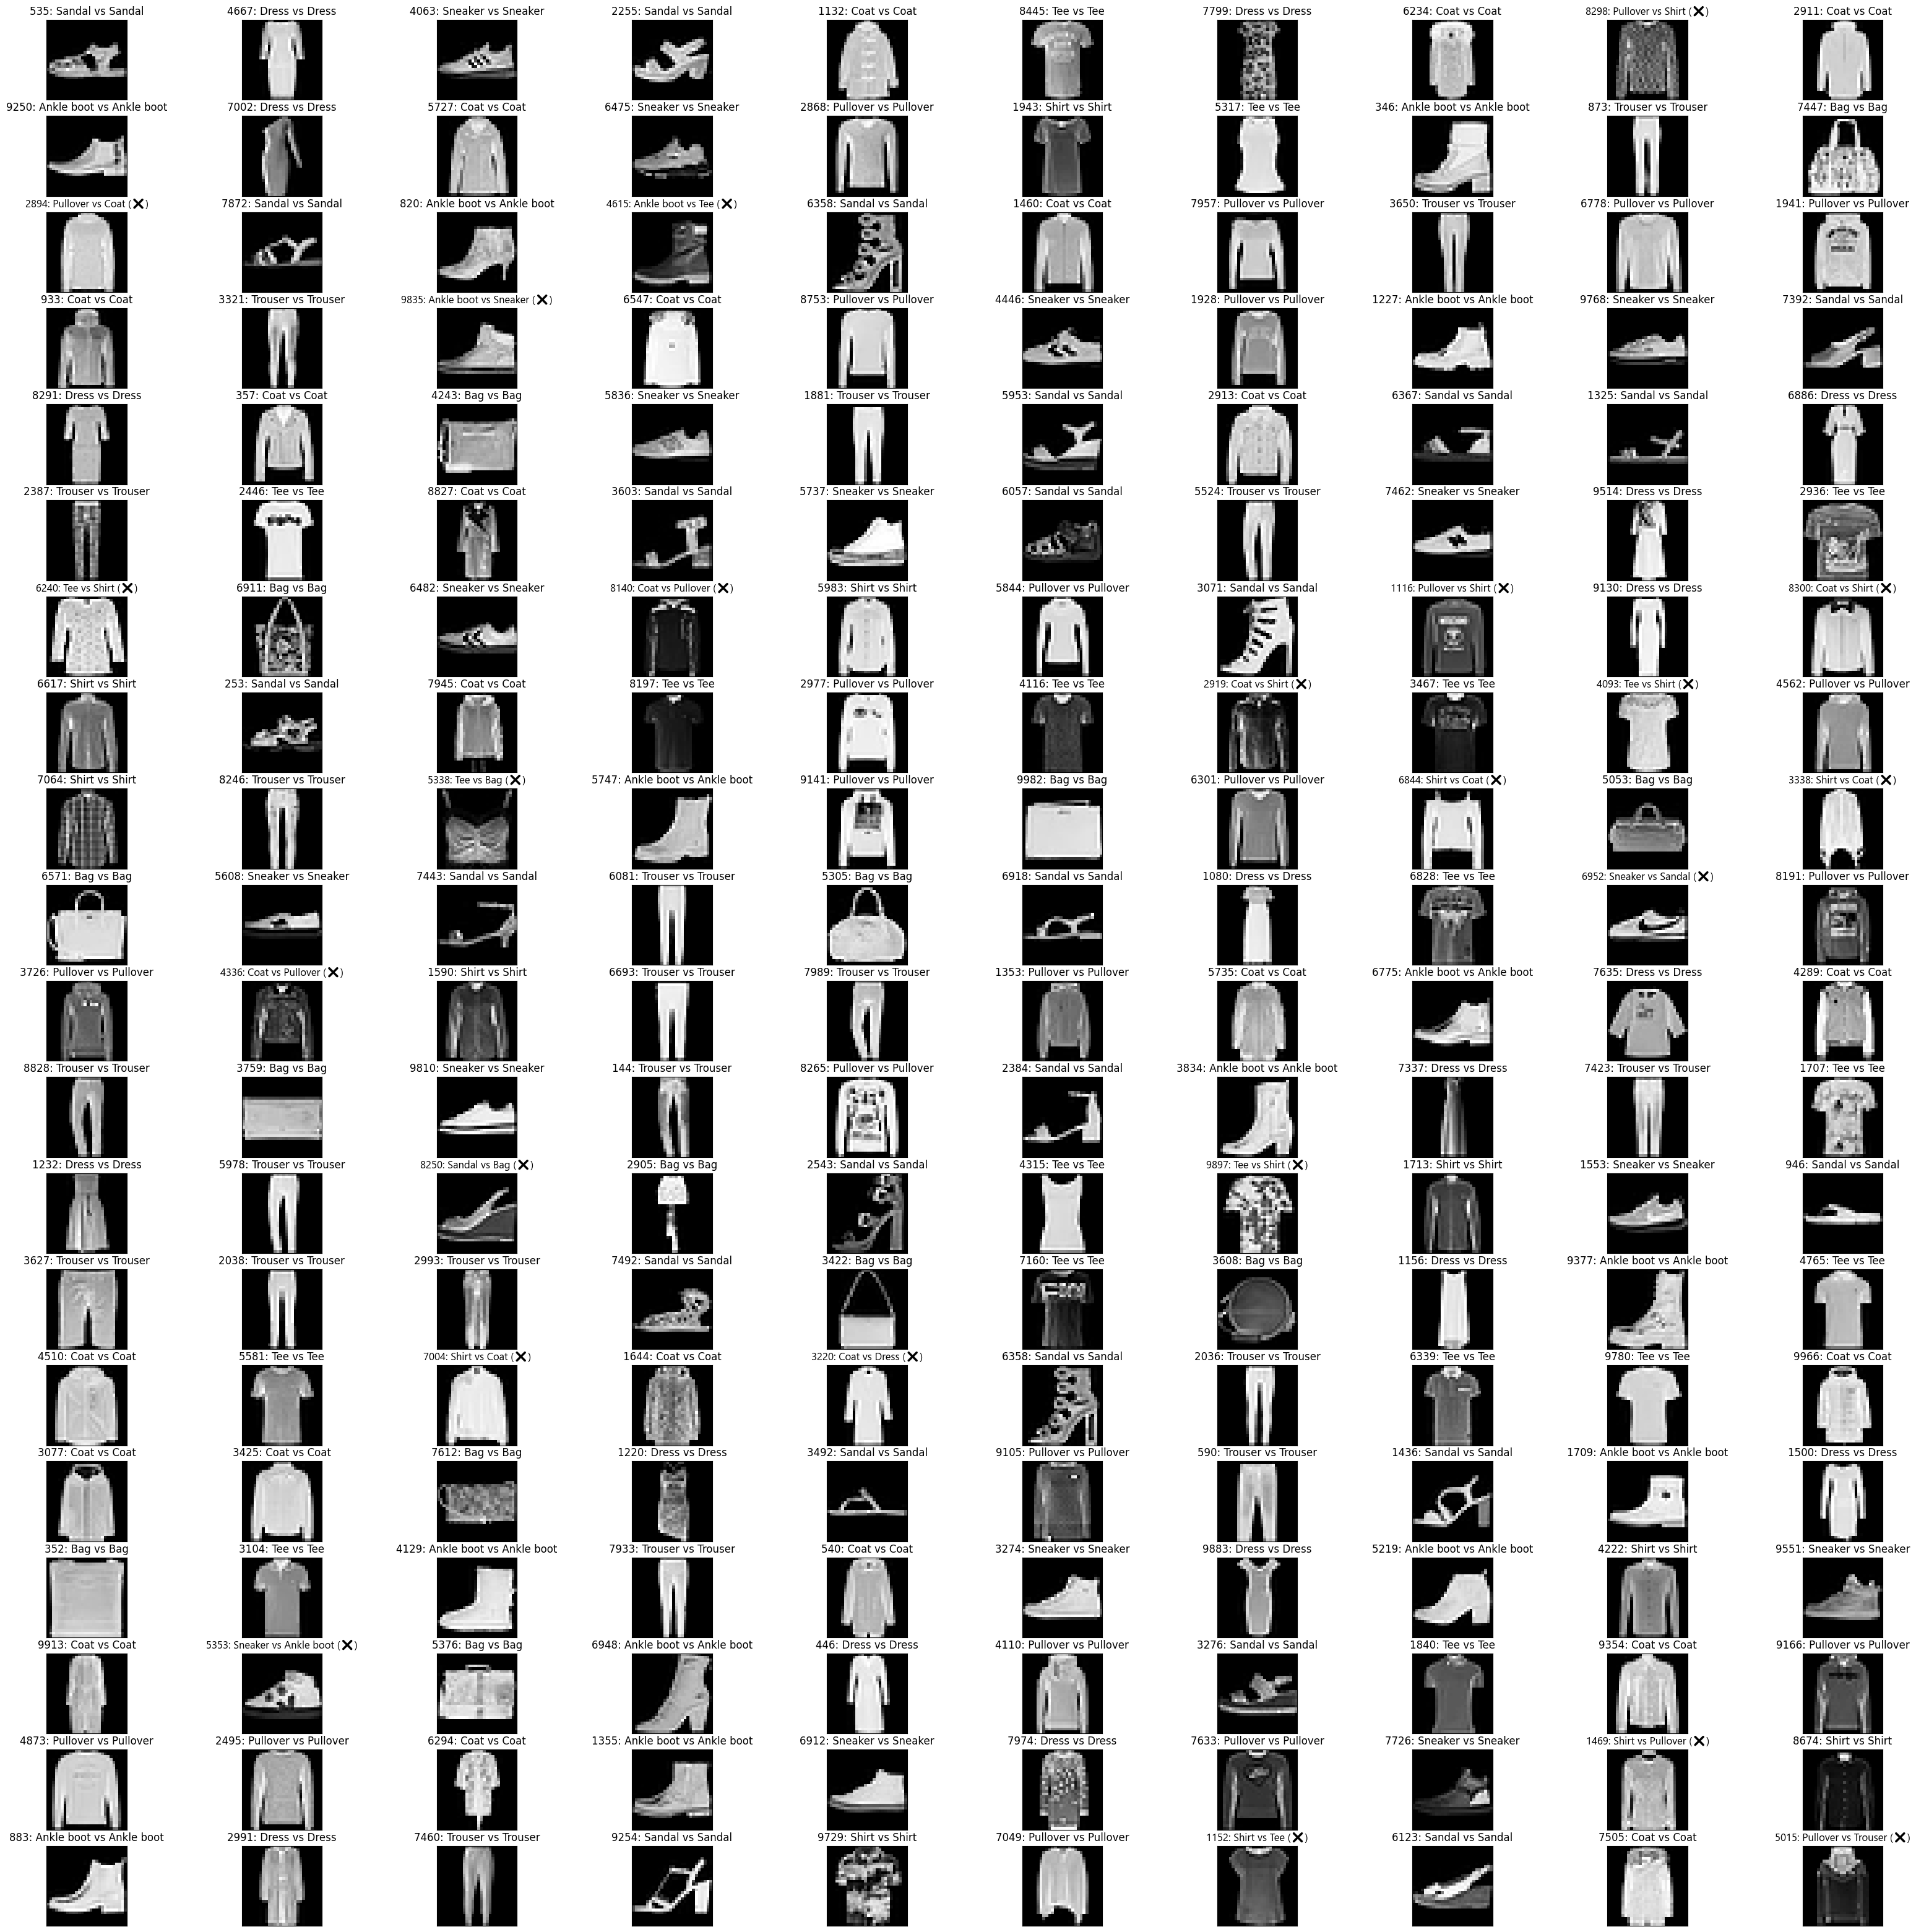

In [22]:
test_data = np.zeros((test_num, 28*28), dtype = np.float32)
test_label = np.zeros((test_num,), dtype = np.float32)

for idx, (img_data, img_label) in enumerate(fashion_data_test):
   test_data[idx]= img_data.squeeze().numpy().flatten() #[1,28,28] to [28,28] to [784]
   test_label[idx] = img_label

total = 0
for i in range(test_num):
    x1 = test_data[i,:].reshape(-1,1)
    y_predict = mlp_predict_MB(x1,w1,b1,w2,b2,w3,b3,w4,b4)
    total += (y_predict==test_label[i])
test_accuracy = 100*total.item()/test_num
print('The accuracy of the MLP: %.4f%% \n' %(test_accuracy))

acc_test = illustration_test_fashion(200, fashion_data_test,w1,b1,w2,b2,w3,b3,w4,b4)
print('\nThe accuracy of the randomly selected 200 samples is %.4f %%' %(acc_test))

### *Evaluation*
- The model has shown signs of **overfitting**, since training accuracy is about 97.5% while evaluation accuracy is only 85.1%